In [158]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from gerrychain import Graph, GeographicPartition, Election, MarkovChain, tree, constraints
from functools import partial
from gerrychain.updaters import Tally, cut_edges
from gerrychain.metrics import polsby_popper
from gerrychain.proposals import recom
import os
from gerrychain.accept import always_accept


In [ ]:
fl = gpd.read_file("FL_VTDs/FL_VTDs.shp")

In [447]:
PROCESSED_SHAPEFILE_PATH = os.path.join(os.getcwd())
NC_PATH = os.path.join(PROCESSED_SHAPEFILE_PATH, "north carolina", "precinct_level_w_election.shp")
ITERATIONS = 100
SAFE_SEAT_THRESHOLD = 0.66
FOUR_FOUR_FIVE = 3.25
FIVE_FIVE_THREE = 2.6
THRE_THREE_THREE_FOUR = 4.33

In [448]:
nc_graph = Graph.from_file(NC_PATH, ignore_errors=True)

/Users/alexisperezmendoza/Desktop/python-mggg/mggg/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/alexisperezmendoza/Desktop/python-mggg/mggg/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [482]:
total_pop = sum(nc_graph.nodes[node]["TOTPOP"] for node in nc_graph.nodes)

In [483]:
partition_445 = tree.recursive_tree_part(nc_graph, [1, 2, 3], total_pop / FOUR_FOUR_FIVE, "TOTPOP", 0.01, 1)
partition_553 = tree.recursive_tree_part(nc_graph, [1, 2, 3], total_pop / FIVE_FIVE_THREE, "TOTPOP", 0.01, 1)
partition_3334 = tree.recursive_tree_part(nc_graph, [1, 2 ,3, 4], total_pop /THRE_THREE_THREE_FOUR, "TOTPOP", 0.01, 1)

In [502]:
nc_election = Election("CongressionalRace" , {"Democratic": "D_VOTES", "Republican": "R_VOTES"})


In [504]:

# Create a new partition with the election results
new_partition445 = GeographicPartition(nc_graph, assignment=partition_445, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })
new_partition553 = GeographicPartition(nc_graph, assignment=partition_553, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })

new_partition3334 = GeographicPartition(nc_graph, assignment=partition_3334, updaters={
        "population": Tally("TOTPOP", alias="population"),
        "white": Tally("NH_WHITE", alias="white"),
        "black": Tally("NH_BLACK", alias="black"),
        "asian": Tally("NH_ASIAN", alias="asian"),
        "hisp": Tally("HISP", alias="hisp"),
        "other": Tally("NH_OTHER", alias="other"),
        "cut_edges": cut_edges,
        "CongressionalRace": nc_election
    })

<AxesSubplot: >

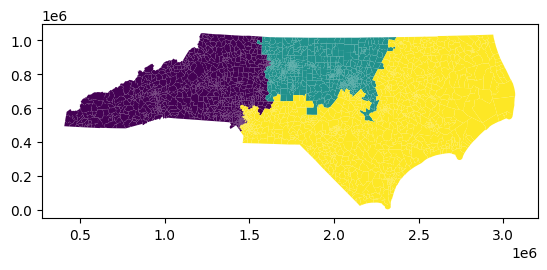

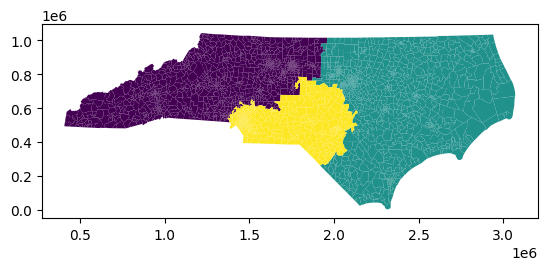

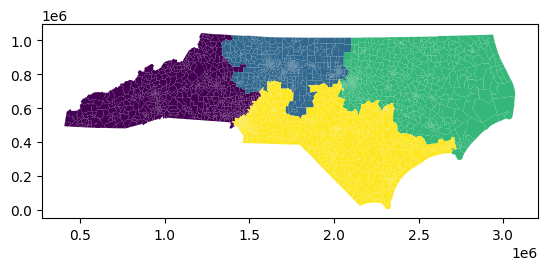

In [500]:
# Ploting the initioal partitions of our three combinations
new_partition445.plot()
new_partition553.plot()
new_partition3334.plot()

In [507]:
ideal_pop445 = total_pop / FOUR_FOUR_FIVE
proposal445 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop445, epsilon=.02, node_repeats=2)
compactness445 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition445["cut_edges"])
)
pop_constraint445 = constraints.within_percent_of_ideal_population(new_partition445, 0.3)

ideal_pop553 = total_pop / FIVE_FIVE_THREE
proposal553 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop553, epsilon=.02, node_repeats=2)
compactness553 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition553["cut_edges"])
)
pop_constraint553 = constraints.within_percent_of_ideal_population(new_partition553, 0.4)

ideal_pop3334 = total_pop / THRE_THREE_THREE_FOUR
proposal3334 = partial(recom, pop_col="TOTPOP", pop_target=ideal_pop3334, epsilon=.02, node_repeats=2)
compactness3334 = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(new_partition3334["cut_edges"])
)
pop_constraint3334 = constraints.within_percent_of_ideal_population(new_partition3334, 0.3)



In [509]:
# Print the population of each district
chain445 = MarkovChain(
    proposal=proposal445,
    constraints=[
        compactness445,
        pop_constraint445
    ],
    accept=always_accept,
    initial_state=new_partition445,
    total_steps=100
)

chain553 = MarkovChain(
    proposal=proposal553,
    constraints=[
        compactness553,
        pop_constraint553
    ],
    accept=always_accept,
    initial_state=new_partition553,
    total_steps=100
)

chain3334 = MarkovChain(
    proposal=proposal3334,
    constraints=[
        compactness3334,
        pop_constraint3334
    ],
    accept=always_accept,
    initial_state=new_partition3334,
    total_steps=100
)


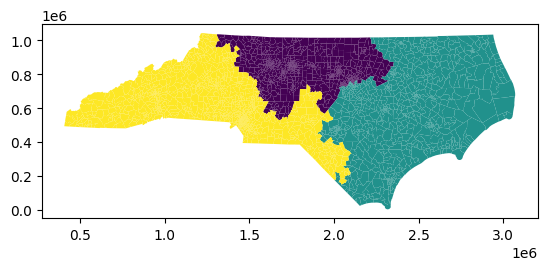

{1: 2976761, 2: 2921677, 3: 3637045}


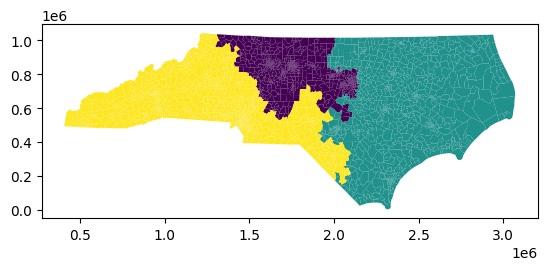

{1: 2969107, 2: 2929331, 3: 3637045}


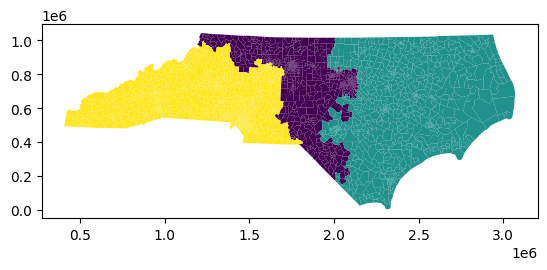

{1: 2881716, 2: 2929331, 3: 3724436}


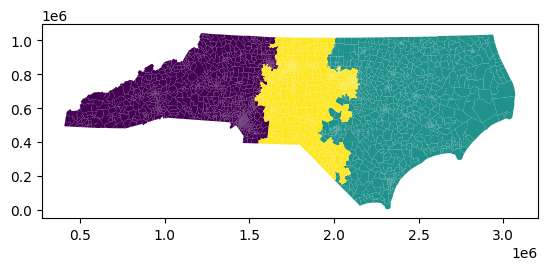

{1: 3648463, 2: 2929331, 3: 2957689}


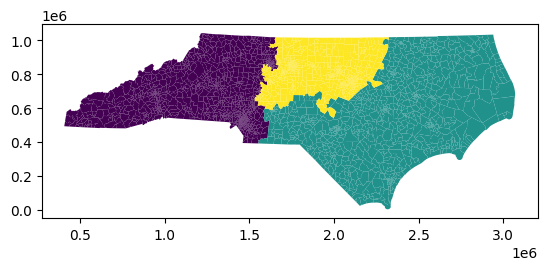

{1: 3648463, 2: 2975664, 3: 2911356}


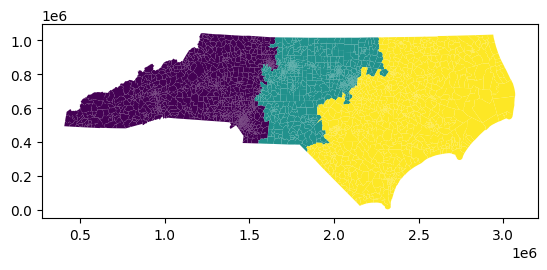

{1: 3648463, 2: 2978928, 3: 2908092}


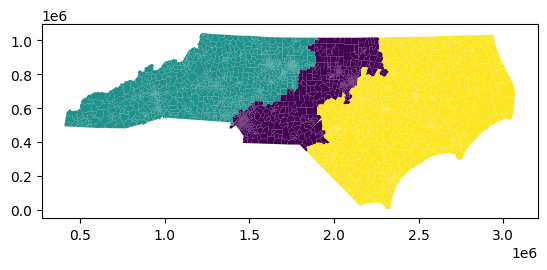

{1: 2979679, 2: 3647712, 3: 2908092}


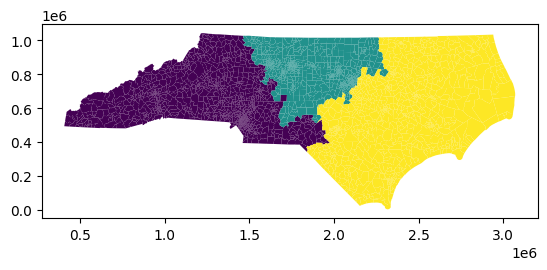

{1: 3669706, 2: 2957685, 3: 2908092}


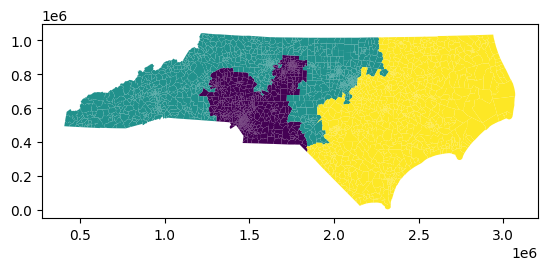

{1: 2985460, 2: 3641931, 3: 2908092}


In [492]:
# Plot each step of the chain and population of each district
for i, step in enumerate(chain445):
    if i > 90:
        step.plot()
        plt.show()
        print(step["population"])
        

In [ ]:
for i, step in enumerate(chain553):
    if i > 90:
        step.plot()
        plt.show()
        print(step["population"])

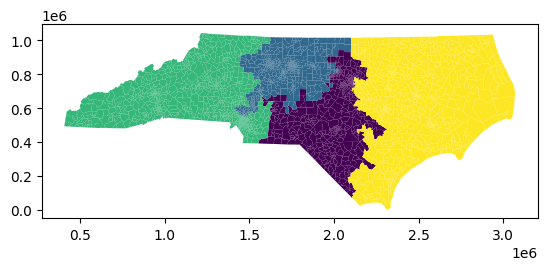

{1: 2206157, 2: 2171253, 3: 2924703, 4: 2233370}


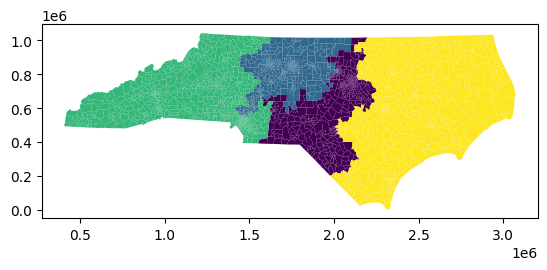

{1: 2216501, 2: 2171253, 3: 2924703, 4: 2223026}


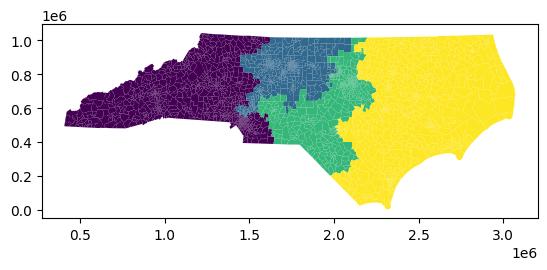

{1: 2896395, 2: 2171253, 3: 2244809, 4: 2223026}


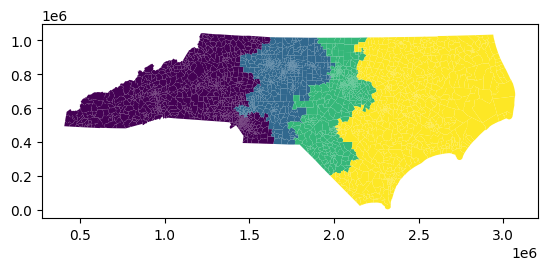

{1: 2896395, 2: 2218608, 3: 2197454, 4: 2223026}


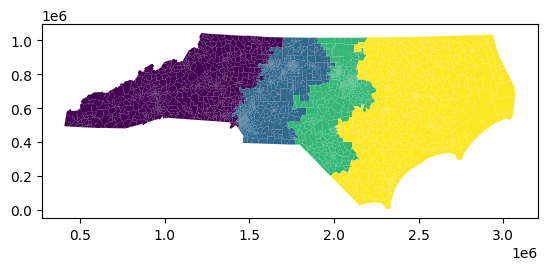

{1: 2184242, 2: 2930761, 3: 2197454, 4: 2223026}


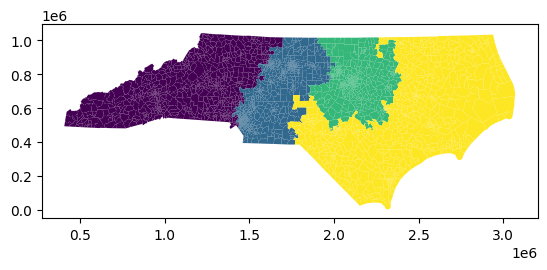

{1: 2184242, 2: 2930761, 3: 2159811, 4: 2260669}


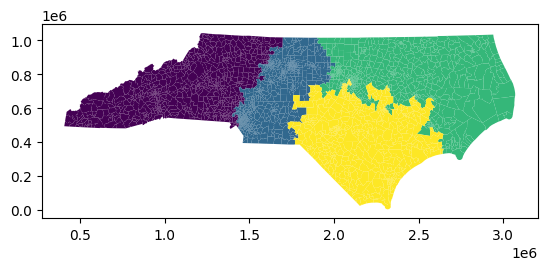

{1: 2184242, 2: 2930761, 3: 2191318, 4: 2229162}


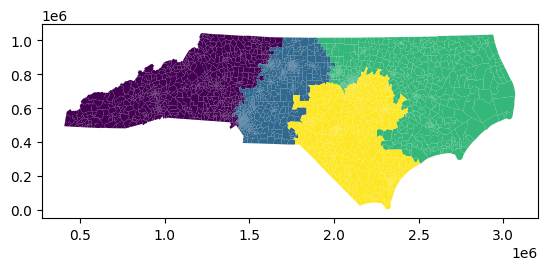

{1: 2184242, 2: 2930761, 3: 2238238, 4: 2182242}


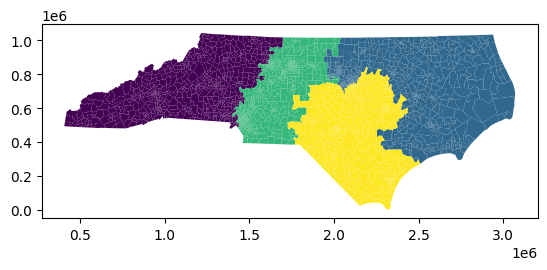

{1: 2184242, 2: 2234483, 3: 2934516, 4: 2182242}


In [510]:
for i, step in enumerate(chain3334):
    if i > 90:
        step.plot()
        plt.show()
        print(step["population"])

In [333]:
polsby_popper_scores445 = pd.DataFrame(polsby_popper(partition) for partition in chain445)
polsby_popper_scores553 = pd.DataFrame(polsby_popper(partition) for partition in chain553)
polsby_popper_scores3334 = pd.DataFrame(polsby_popper(partition) for partition in chain3334)


In [518]:
d_percents445 = [sorted(partition["CongressionalRace"].percents("Democratic")) for partition in chain445]
data445 = pd.DataFrame(d_percents445)

In [514]:
d_percents553 = [sorted(partition["CongressionalRace"].percents("Democratic")) for partition in chain553]
data553 = pd.DataFrame(d_percents553)

In [511]:
d_percents3334 = [sorted(partition["CongressionalRace"].percents("Democratic")) for partition in chain3334]
data3334 = pd.DataFrame(d_percents3334)


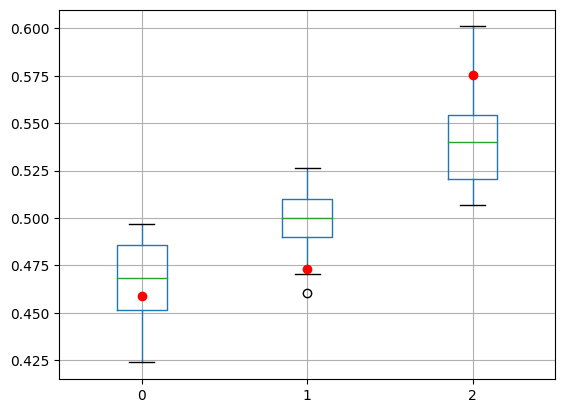

In [519]:
ax445 = data445.boxplot(positions=range(len(data445.columns)))
plt.plot(data445.iloc[0], "ro")

plt.show()

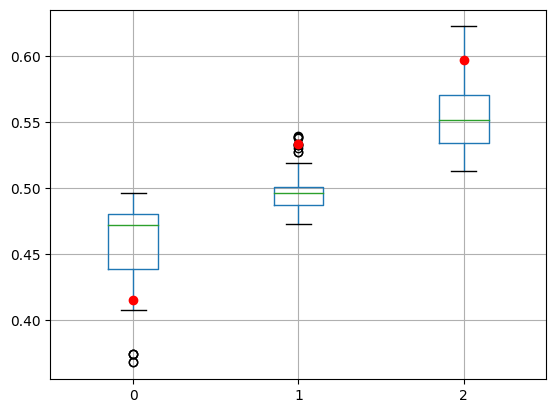

In [515]:
ax553 = data553.boxplot(positions=range(len(data553.columns)))
plt.plot(data553.iloc[0], "ro")

plt.show()

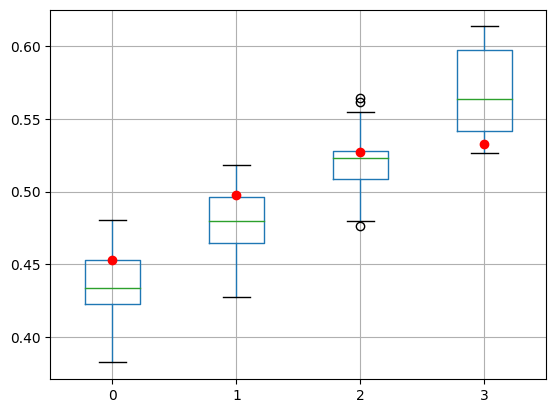

In [516]:
ax3334 = data3334.boxplot(positions=range(len(data3334.columns)))
plt.plot(data3334.iloc[0], "ro")

plt.show()